## EA run comparison

Read all experiment data:

In [ ]:
import os
import pandas as pd
import glob
import re
import numpy as np

run_directory_prefix = "../models/NarxModelSearch/runs/"
file_name_pattern = "*Runs.csv"
columns = ["datetime", "iteration", "island", "cvMseMean", "cvMseStd", "cvSmapeMean", "cvSmapeStd", "holdoutRmse", "holdoutSmape", "holdoutMape", "holdoutMse", "holdoutIoa", "full_parameters"]

experiment_directories = ["18CellularAutomata3DGrid3x3x3_5AgentsO3_1994-2018_16_stations_calendar", 
                          "18CellularAutomata3DGrid3x3x3_20AgentsO3_1994-2018_16_stations_calendar", 
                          "18Islands20AgentsO3_1994-2018_16_stations_calendar", 
                          "18Islands5AgentsO3_1994-2018_16_stations_calendar",
                          "18CellularAutomata3DGrid3x3x3_5AgentsPM10_1994-2018_16_stations_calendar",
                          "18Islands20AgentsPM10_1994-2018_16_stations_calendar",
                          "18Islands5AgentsPM10_1994-2018_16_stations_calendar"
                         ]

run_directories = []
for experiment_directory in experiment_directories:
    new_run_directory = run_directory_prefix + experiment_directory + "/"
#     print("new_run_directory:", new_run_directory)
    run_directories.append(new_run_directory)

worker_directories = ["local", "TX2"]

# print(run_directories)

dirs_list = []
for run_directory in run_directories:
    dirs_list.append(os.listdir(run_directory))
#     print("dirs:", os.listdir(run_directory))
    
for dirs in dirs_list:
    for item in dirs:
        if item not in worker_directories:
            sub_items = os.listdir(run_directories[0] + item)
            for sub_item in sub_items:
                sub_path = item +"/" + sub_item
#                 print("sub_path:", item +"/" + sub_item)
                worker_directories.append(sub_path)
            
# print("worker_directories:", worker_directories)

paths = []
for run_directory in run_directories:
    for worker_directory in worker_directories:
        experiment = ""
        if run_directory.startswith(run_directory_prefix):
            experiment = run_directory[len(run_directory_prefix):-1]
#         print("experiment:", experiment)
        paths.append((run_directory + worker_directory + "/logs/", worker_directory, experiment))

# print(len(paths))
    
frames = []
for path in paths:
    for csv_file_path in glob.glob(path[0] + file_name_pattern):
#         print("csv_file_path:", csv_file_path)
#         print("csv_file     :", csv_file)
        df = pd.read_csv(csv_file_path, names=columns, engine="python", index_col="datetime", parse_dates=True)
    
        if "EC2" in path[1]:  # EC2 -> + 1 hour (Ireland)
            df.index = df.index + 3600
        if "TX2" in path[1]:  # TX2 -> + 2 hours (UTC)        
            df.index = df.index + 3600 * 2
    
        df.sort_index(inplace=True)
        df["optimizer"] = str(re.search('(.{1,6})Runs.csv', os.path.basename(csv_file_path)).group(1))
        df["worker"] = path[1]
        df["experiment"] = path[2]
        df["cvSmapeMeanAccuracy"] = 100 - df["cvSmapeMean"]
        df["holdoutSmapeAccuracy"] = 100 - df["holdoutSmape"]        
#         print("df.shape", df.shape)
        frames.append(df)
#         break

df = pd.concat(frames)
df.sort_index(inplace=True)

print("df.shape:", df.shape)
df.tail()        

In [2]:
import numpy as np
import matplotlib.pyplot as plt

variables = [
#     "cvSmapeMeanAccuracy", 
#     "holdoutMse",
    "holdoutSmapeAccuracy",
#     "holdoutIoa"
]
figure_size = [20, 16]
remove_outliers = False
outlier_std = 3
minimizing = False

def getMinimizingMaximizingArray(k, minimizing=True):
    minsArray = []
    minValue = k[0]
    for value in np.array(k):
        if minimizing:
            if value < minValue:
                minValue = value
        else:
            if value > minValue:
                minValue = value
        minsArray.append(minValue)    
    return np.array(minsArray)
    
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

for current_experiment in experiment_directories:
    
    legends = []
    for variable in variables:    
       
        df2 = df.loc[df["experiment"] == current_experiment]
        
#         df2 = df2.loc[df2["optimizer"] != "ls"]
        
        df2 = df2.drop_duplicates()
        df2.sort_index(inplace=True)
    
        if remove_outliers:
            df2 = df2[~(np.abs(df2[variable] - df2[variable].mean()) > (outlier_std * df2[variable].std()))]
    
        dict_points = {}        
        for optimizer in df2["optimizer"].unique():
            dict_points[optimizer + "_y"] = []
            dict_points[optimizer + "_x"] = []
        i = 0
        for index, row in df2.iterrows():
            optimizer = row["optimizer"]
            dict_points[optimizer + "_y"].append(row[variable])
            dict_points[optimizer + "_x"].append(i)            
            i += 1
    
        x = np.array(range(0, len(df2[variable])))
        y = df2[variable].values 
        
        fig, ax = plt.subplots(1, 1, figsize=figure_size)
        ax.set_ylabel(variable)
        ax.set_xlabel('# Fitness Evaluations')

        # Linear regression trend
        z = np.polyfit(x, y, 1) 
        trendpoly1d = np.poly1d(z)
        ax.plot(x, trendpoly1d(x) , 'k--')
        legends.append("trend " + variable + ": {:.2f}*x + {:.2f}".format(z[0], z[1]))
        
        z2 = np.polyfit(x, y, 2) 
        trendpoly2d = np.poly1d(z2)
        ax.plot(x, trendpoly2d(x) , 'r--')
        legends.append("trend 2 degree polynomial")
        
        z12 = np.polyfit(x, y, 12) 
        trendpoly12d = np.poly1d(z12)
        ax.plot(x, trendpoly12d(x) , 'c--')
        legends.append("trend 12 degree polynomial")
                
        # Scatter plot all data points based on method    
        i = 0
        styles = ["x", ".", "^", "+", "v", "1", "*"]
        for optimizer in df2["optimizer"].unique():
            ax.plot(dict_points[optimizer + "_x"], dict_points[optimizer + "_y"], styles[i]);
            legends.append(optimizer)
            i += 1

        ax.plot(x, getMinimizingMaximizingArray(df2[variable].values, minimizing), "b-");
        legends.append("minimizing " + variable)
        
        ax.legend(legends)
        best_method = df2["optimizer"].loc[df2[variable].idxmin()]
        ax.set_title('{} (evals: {}, min: {:.2f}, max: {:.2f}, median: {:.2f} +/- {:.2f}, mean: {:.2f} +/- {:.2f}, best: {}) - Experiment: {}'
                     .format(variable, len(df2[variable]), df2[variable].min(), df2[variable].max(), df2[variable].median(), df2[variable].mad(), 
                             df2[variable].mean(), df2[variable].std(), best_method, current_experiment))
        ax.grid(True) 
    
#         break
#     break

## Worker execution times: Bar chart with error bars

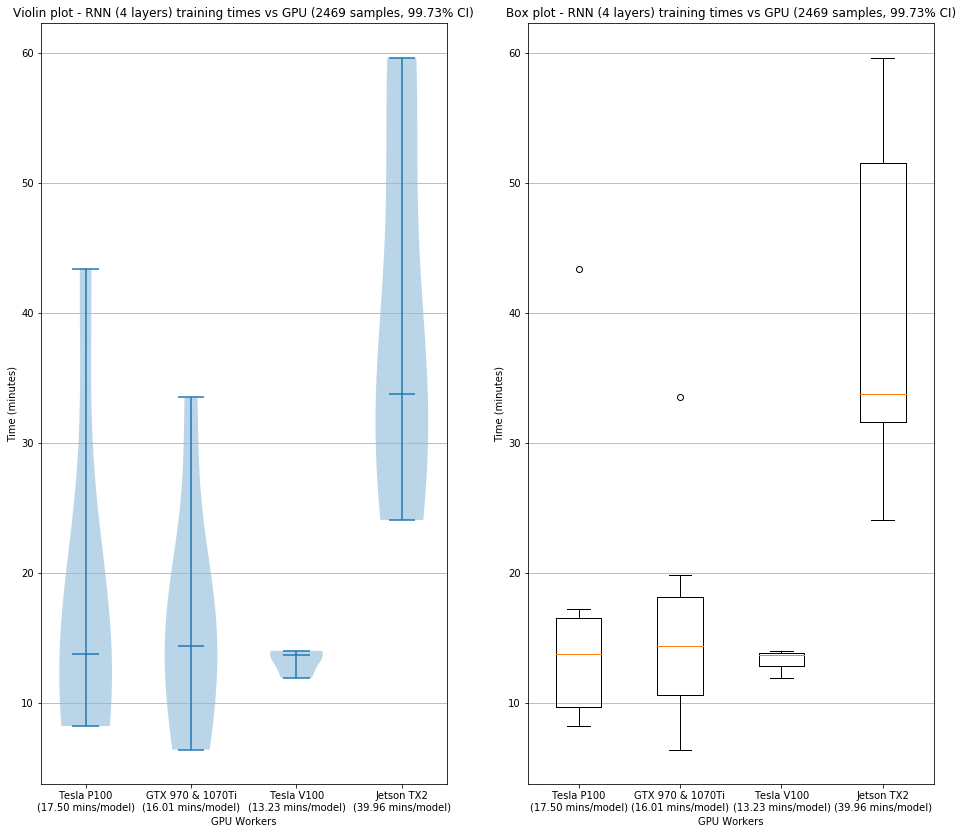

In [3]:
import math
import matplotlib.pyplot as plt
import numpy as np

def flatten(seq, container=None):
    if container is None:
        container = []
    for s in seq:
        try:
            iter(s)  # check if it's iterable
        except TypeError:
            container.append(s)
        else:
            flatten(s, container)
    return container

workers = df["worker"].unique()

means = []
samples = 0
outlier_std = 3
for current_worker in workers:
    experiment_means = []
    for current_experiment in experiment_directories:
        df_worker = df.loc[df["experiment"] == current_experiment]
        df_worker = df_worker.loc[df_worker["worker"] == current_worker]
        df_worker = df_worker.drop_duplicates()
        df_worker = df_worker.dropna()
        df_worker.sort_index(inplace=True)
        df_worker['datetimestamp'] = df_worker.index                
        df_worker = df_worker[~(np.abs(df_worker["datetimestamp"] - df_worker["datetimestamp"].mean()) > (outlier_std * df_worker["datetimestamp"].std()))]        
        diff = df_worker["datetimestamp"].diff().dropna()
        mean = diff.mean(skipna=True)
        if "P100" in current_worker or "4xV100" in current_worker:
            mean *= 4        
        if mean is not None and not math.isnan(mean):
            samples += diff.size
            experiment_means.append(mean / 60.0)
    means.append(experiment_means)

# Plot

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 14))
workers = list(workers)
fourV100 = workers.index('EC2/4xV100a')
oneV100 = workers.index('EC2/1xV100')
means[fourV100].append(means[oneV100][0])
del means[oneV100]

all_data = means
labels = []
for x, y in zip(['Tesla P100', 'GTX 970 & 1070Ti', 'Tesla V100', 'Jetson TX2'], [np.mean(x) for x in all_data]):
    labels.append("{}\n({:.2f} mins/model)".format(x, y))

axes[0].violinplot(all_data, showmeans=False, showmedians=True)
axes[0].set_title('Violin plot - RNN (4 layers) training times vs GPU ({} samples, 99.73% CI)'.format(samples))
axes[1].boxplot(all_data)
axes[1].set_title('Box plot - RNN (4 layers) training times vs GPU ({} samples, 99.73% CI)'.format(samples))
for ax in axes:
    ax.yaxis.grid(True)
    ax.set_xticks([y+1 for y in range(len(all_data))])
    ax.set_xlabel('GPU Workers')
    ax.set_ylabel('Time (minutes)')
plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
         xticklabels=labels)
plt.savefig("rnnTrainingTimes.svg")
plt.savefig("rnnTrainingTimes.png")
plt.show()

price_per_model_hour_std [495.39481663  26.98099847 110.15980803  64.96931466]


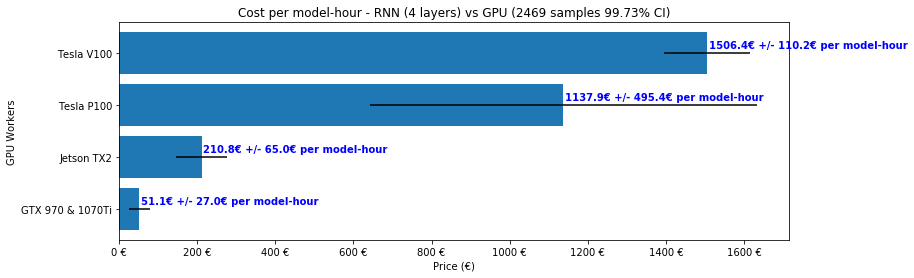

In [4]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np


models_per_hour = []
models_per_hour_std = []
for gpu_worker in all_data:
    models_per_hour.append(np.mean(60.0 / np.array(gpu_worker)))
    models_per_hour_std.append(np.std(60.0 / np.array(gpu_worker)))
prices = [5281, (136 + 369) / 2.0, 6865, 352]
price_per_model_hour = np.array(prices) / np.array(models_per_hour)

price_per_model_hour_std = price_per_model_hour * (np.array(models_per_hour_std) / np.array(models_per_hour))
print("price_per_model_hour_std", price_per_model_hour_std)

gpu_workers = ['Tesla P100', 'GTX 970 & 1070Ti', 'Tesla V100', 'Jetson TX2']
price_per_model_hour = [x for y,x in sorted(zip(gpu_workers, price_per_model_hour))]
gpu_workers = [y for y,x in sorted(zip(gpu_workers, price_per_model_hour))]

price_per_model_hour_std = [26.98099847, 64.96931466, 495.39481663,  110.15980803]  # TODO: hardcoded

x = np.arange(4)
def millions(x, pos):
    return '{:.0f} €'.format(x)

formatter = FuncFormatter(millions)

fig, ax = plt.subplots(figsize=(12, 4))
ax.xaxis.set_major_formatter(formatter)
plt.barh(x, price_per_model_hour, xerr=price_per_model_hour_std)
# plt.barh(x, price_per_model_hour)
ax.set_title('Cost per model-hour - RNN (4 layers) vs GPU ({} samples 99.73% CI)'.format(samples))
ax.set_ylabel('GPU Workers')
ax.set_xlabel('Price (€)')
plt.yticks(x, gpu_workers)
for i, v in enumerate(price_per_model_hour):
    ax.text(v + 4, i + 0.1, str(round(v, 1)) + "€ +/- {:.1f}€ per model-hour".format(price_per_model_hour_std[i]) , color='blue', fontweight='bold')
plt.show()

## All models structure

In [12]:
import os
import pandas as pd
import glob
import re
import numpy as np

run_directory_prefix = "../models/NarxModelSearch/runs/"
file_name_pattern = "*Runs.csv"
columns = ["datetime", "iteration", "island", "cvMseMean", "cvMseStd", "cvSmapeMean", "cvSmapeStd", "holdoutRmse", "holdoutSmape", "holdoutMape", "holdoutMse", "holdoutIoa", "full_parameters"]

experiment_directories = ["18CellularAutomata3DGrid3x3x3_5AgentsO3_1994-2018_16_stations_calendar", 
                          "18CellularAutomata3DGrid3x3x3_20AgentsO3_1994-2018_16_stations_calendar", 
                          "18Islands20AgentsO3_1994-2018_16_stations_calendar", 
                          "18Islands5AgentsO3_1994-2018_16_stations_calendar",
                          "18CellularAutomata3DGrid3x3x3_5AgentsPM10_1994-2018_16_stations_calendar",
                          "18Islands20AgentsPM10_1994-2018_16_stations_calendar",
                          "18Islands5AgentsPM10_1994-2018_16_stations_calendar"
                         ]

run_directories = []
for experiment_directory in experiment_directories:
    new_run_directory = run_directory_prefix + experiment_directory + "/"
#     print("new_run_directory:", new_run_directory)
    run_directories.append(new_run_directory)

worker_directories = ["local", "TX2"]

# print(run_directories)

dirs_list = []
for run_directory in run_directories:
    dirs_list.append(os.listdir(run_directory))
#     print("dirs:", os.listdir(run_directory))
    
for dirs in dirs_list:
    for item in dirs:
        if item not in worker_directories:
            sub_items = os.listdir(run_directories[0] + item)
            for sub_item in sub_items:
                sub_path = item +"/" + sub_item
#                 print("sub_path:", item +"/" + sub_item)
                worker_directories.append(sub_path)
            
# print("worker_directories:", worker_directories)

paths = []
for run_directory in run_directories:
    for worker_directory in worker_directories:
        experiment = ""
        if run_directory.startswith(run_directory_prefix):
            experiment = run_directory[len(run_directory_prefix):-1]
#         print("experiment:", experiment)
        paths.append((run_directory + worker_directory + "/logs/", worker_directory, experiment))

# print(len(paths))
    
frames = []
for path in paths:
    for csv_file_path in glob.glob(path[0] + file_name_pattern):
#         print("csv_file_path:", csv_file_path)
#         print("csv_file     :", csv_file)
        df = pd.read_csv(csv_file_path, names=columns, engine="python", index_col="datetime", parse_dates=True)
    
        if "EC2" in path[1]:  # EC2 -> + 1 hour (Ireland)
            df.index = df.index + 3600
        if "TX2" in path[1]:  # TX2 -> + 2 hours (UTC)        
            df.index = df.index + 3600 * 2
    
        df.sort_index(inplace=True)
        df["optimizer"] = str(re.search('(.{1,6})Runs.csv', os.path.basename(csv_file_path)).group(1))
        df["worker"] = path[1]
        df["experiment"] = path[2]
        df["cvSmapeMeanAccuracy"] = 100 - df["cvSmapeMean"]
        df["holdoutSmapeAccuracy"] = 100 - df["holdoutSmape"]
        
        full_parameters = []
        for params in df["full_parameters"].tolist():
#             print(params)
            full_parameters.append([float(z) for z in params.replace('[', '').replace(']', '').split(", ")])

        df["full_parameters"] = full_parameters        
        a = ["batch_size",
            "epoch_size",
            "optimizer",
            "units1",
            "units2",
            "units3",
            "dropout1",
            "dropout2",
            "dropout3",
            "recurrent_dropout1",
            "recurrent_dropout2",
            "recurrent_dropout3",
            "gaussian_noise_std1",
            "gaussian_noise_std2",
            "gaussian_noise_std3",
            "batch_normalization1",
            "batch_normalization2",
            "batch_normalization3",
            "gaussian_noise1",
            "gaussian_noise2",
            "gaussian_noise3",
            "layer_type1",
            "layer_type2",
            "layer_type3",
            "layer_initializer1",
            "layer_initializer2",
            "layer_initializer3"]
            
        c = 0
        for asdf in zip(*full_parameters):
            df[a[c]] = asdf
            c +=1
        
        frames.append(df)
#         break

df = pd.concat(frames)
df.sort_index(inplace=True)

print("df.shape:", df.shape)
df.tail()        

df.shape: (6659, 43)


,iteration,island,cvMseMean,cvMseStd,cvSmapeMean,cvSmapeStd,holdoutRmse,holdoutSmape,holdoutMape,holdoutMse,...,batch_normalization3,gaussian_noise1,gaussian_noise2,gaussian_noise3,layer_type1,layer_type2,layer_type3,layer_initializer1,layer_initializer2,layer_initializer3
datetime,,,,,,,,,,,,,,,,,,,,,
1563747100,52,1,483.107126,44.939292,13.379213,0.775774,29.238121,14.629771,inf,854.867735,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,5.00000,9.000000,9.00000,9.000000
1563747702,53,1,482.562458,45.272642,13.336051,0.810653,29.224129,14.647241,inf,854.049699,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,5.00000,9.000000,9.00000,9.000000
1563748389,54,1,172.173384,60.361243,8.614378,1.554654,24.084382,13.177726,inf,580.057433,...,0.334156,0.356486,0.009281,0.706068,0.599423,2.095104,3.52017,7.876501,6.94048,7.487607
1563749134,55,1,172.674499,58.940749,8.665994,1.556883,21.596358,12.478397,inf,466.402700,...,0.334156,0.356486,0.009281,0.706068,0.599423,2.095104,3.52017,7.876501,6.94048,7.487607
1563750788,56,1,206.050960,57.548934,9.374015,1.505576,18.609927,10.336197,inf,346.329389,...,0.334156,0.356486,0.009281,0.706068,0.599423,2.095104,3.52017,7.876501,6.94048,7.487607


In [13]:
units1 = []
units2 = []
units3 = []
layer_type1 = []
layer_type2 = []
layer_type3 = []

experiment_directories = ["18CellularAutomata3DGrid3x3x3_5AgentsO3_1994-2018_16_stations_calendar", 
                          "18CellularAutomata3DGrid3x3x3_20AgentsO3_1994-2018_16_stations_calendar",  # BEST O3
                          "18Islands20AgentsO3_1994-2018_16_stations_calendar", 
                          "18Islands5AgentsO3_1994-2018_16_stations_calendar",
                          "18CellularAutomata3DGrid3x3x3_5AgentsPM10_1994-2018_16_stations_calendar",
                          "18Islands20AgentsPM10_1994-2018_16_stations_calendar",  # BEST PM10
                          "18Islands5AgentsPM10_1994-2018_16_stations_calendar"
                         ]
current_experiment = experiment_directories[1]

df_models = df.loc[df["experiment"] == current_experiment]
for element in df_models["full_parameters"]:
    units1.append(element[3])
    units2.append(element[4])
    units3.append(element[5])
    layer_type1.append(np.around(element[21], decimals=0).astype(int))
    layer_type2.append(np.around(element[22], decimals=0).astype(int))
    layer_type3.append(np.around(element[23], decimals=0).astype(int))
#     layer_type1.append(element[15])
#     layer_type2.append(element[16])
#     layer_type3.append(element[17])
units = [units1, units2, units3]    
layer_types = [layer_type1, layer_type2, layer_type3]

## Best:

In [ ]:
best_df_model = df_models.loc[df_models["holdoutSmapeAccuracy"] == df_models["holdoutSmapeAccuracy"].max()]
best_pm10_params = best_df_model["full_parameters"]
layer_types_list = ["LSTM", "BiLSTM", "GRU", "BiGRU", "RNN", "BiRNN"]
for element in best_pm10_params:
    print("\nBest model(units):")
    print(np.around(element[3], decimals=0).astype(int), end=", ")
    print(np.around(element[4], decimals=0).astype(int), end=", ")
    print(np.around(element[5], decimals=0).astype(int), end="")
    print("\nBest model(layers):")
    print(layer_types_list[np.around(element[21], decimals=0).astype(int)], end=", ")
    print(layer_types_list[np.around(element[22], decimals=0).astype(int)], end=", ")
    print(layer_types_list[np.around(element[23], decimals=0).astype(int)], end=", ")
best_df_model
list(best_pm10_params)
np.around(list(best_pm10_params), decimals=0).astype(int)
print("\nMax holdoutSmapeAccuracy: {:.2f}%".format(df_models["holdoutSmapeAccuracy"].max()))

## Worst:

In [ ]:
worst_df_model = df_models.loc[df_models["holdoutSmapeAccuracy"] == df_models["holdoutSmapeAccuracy"].min()]
worst_pm10_params = worst_df_model["full_parameters"]
layer_types_list = ["LSTM", "BiLSTM", "GRU", "BiGRU", "RNN", "BiRNN"]
for element in worst_pm10_params:
    print("\nBest model(units):")
    print(np.around(element[3], decimals=0).astype(int), end=", ")
    print(np.around(element[4], decimals=0).astype(int), end=", ")
    print(np.around(element[5], decimals=0).astype(int), end="")
    print("\nBest model(layers):")
    print(layer_types_list[np.around(element[21], decimals=0).astype(int)], end=", ")
    print(layer_types_list[np.around(element[22], decimals=0).astype(int)], end=", ")
    print(layer_types_list[np.around(element[23], decimals=0).astype(int)], end=", ")

worst_df_model    
list(worst_pm10_params)
np.around(list(worst_pm10_params), decimals=0).astype(int)
print("\nMax holdoutSmapeAccuracy: {:.2f}%".format(df_models["holdoutSmapeAccuracy"].min()))

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 14))
samples = len(units[0])
labels = ["units1", "units2", "units3"]
all_data = units

axes[0].violinplot(all_data, showmeans=False, showmedians=True)
axes[0].set_title('Violin plot - RNN (4 layers) training times vs GPU ({} samples)'.format(samples))
axes[1].boxplot(all_data)
axes[1].set_title('Box plot - RNN (4 layers) training times vs GPU ({} samples)'.format(samples))
for ax in axes:
    ax.yaxis.grid(True)
    ax.set_xticks([y+1 for y in range(len(all_data))])
    ax.set_xlabel('GPU Workers')
    ax.set_ylabel('Time (minutes)')
plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
         xticklabels=labels)
plt.show()

In [ ]:
# Plot
import math
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 14))
samples = len(layer_types[0])
labels = ["layer_type1", "layer_type2", "layer_type3"]
all_data = layer_types

axes[0].violinplot(all_data, showmeans=False, showmedians=True)
axes[0].set_title('Violin plot - RNN (4 layers) training times vs GPU ({} samples)'.format(samples))
axes[1].boxplot(all_data)
axes[1].set_title('Box plot - RNN (4 layers) training times vs GPU ({} samples)'.format(samples))
for ax in axes:
    ax.yaxis.grid(True)
    ax.set_xticks([y+1 for y in range(len(all_data))])
    ax.set_xlabel('GPU Workers')
    ax.set_ylabel('Time (minutes)')
plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
         xticklabels=labels)
plt.show()

In [42]:
# df_models
df_models2 = df.loc[df["experiment"] == current_experiment]
a.append("holdoutSmapeAccuracy")
df_models3 = df_models2[a]

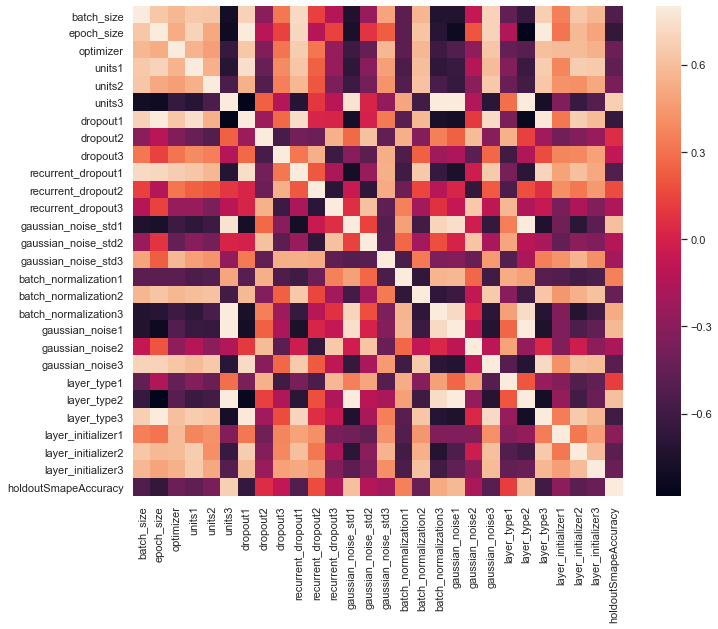

In [44]:
#correlation matrix
import seaborn as sns
corrmat = df_models3.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

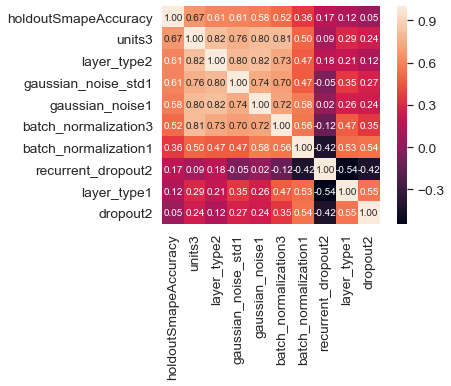

In [47]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'holdoutSmapeAccuracy')['holdoutSmapeAccuracy'].index
cm = np.corrcoef(df_models3[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

C:\Users\temp3rr0r\Anaconda3\envs\tensorflowLast\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


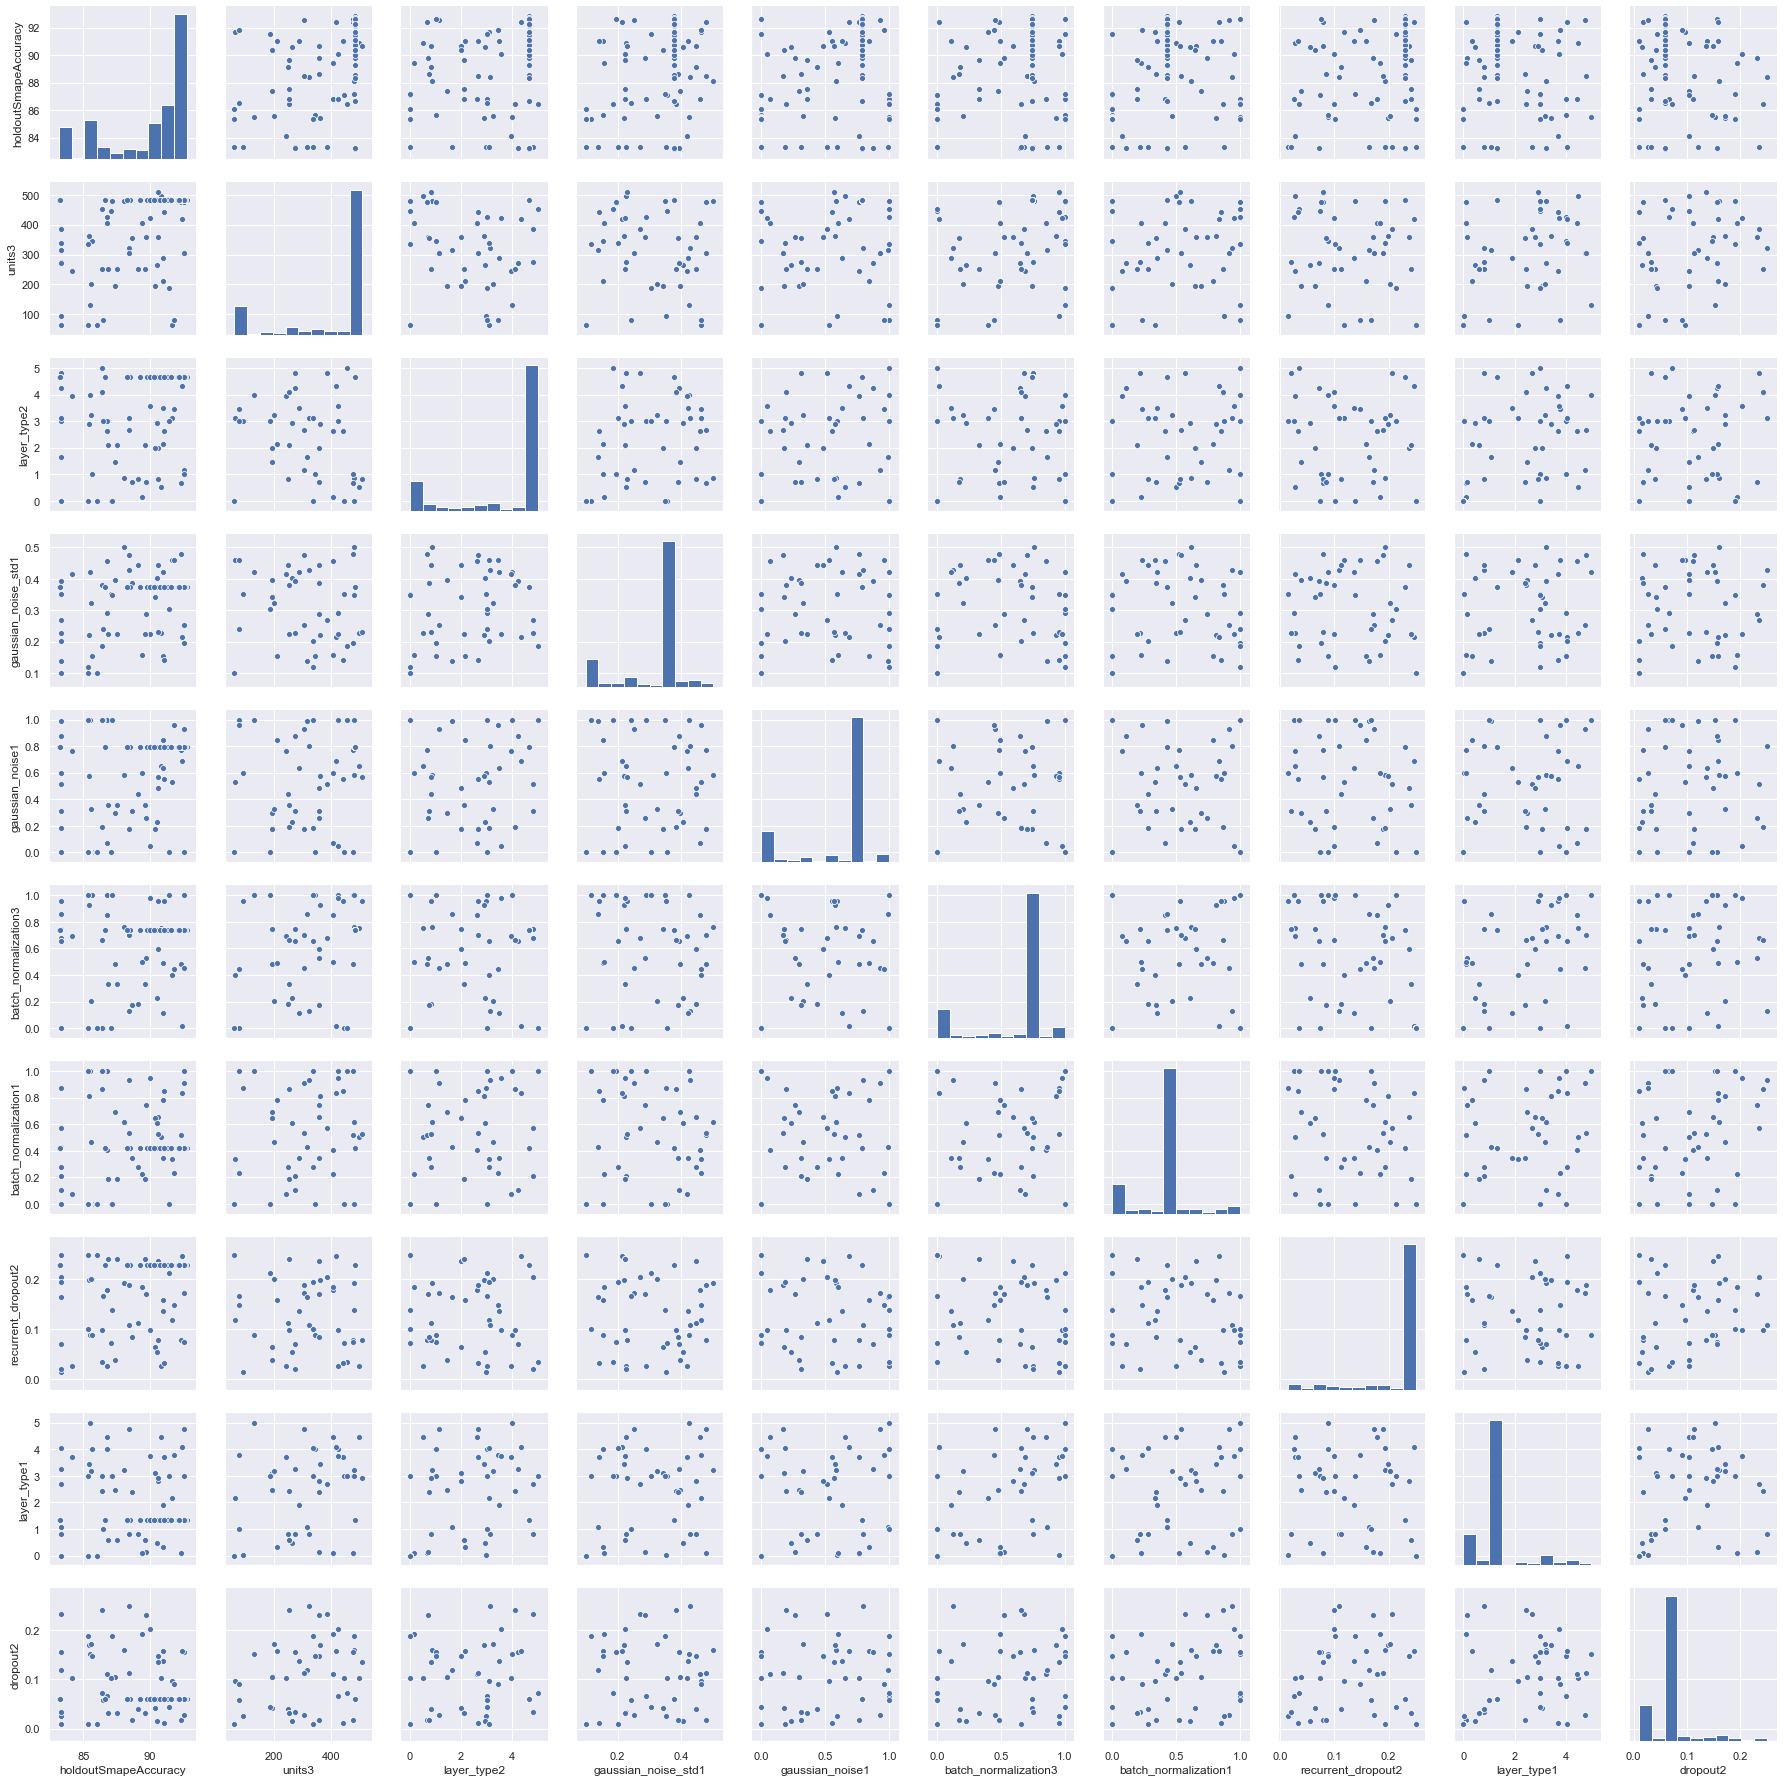

In [48]:
#scatterplot
sns.set()
sns.pairplot(df_models3[cols], size = 2.5)
plt.show();